# Using pre-trained convnet

![title](./pics/conv_pre_training.png)

In [1]:
# imports
import sys
import os, shutil
import numpy as np

# keras imports 
from keras import layers
from keras import models
from keras import optimizers
from keras.datasets import mnist
from keras.applications import VGG16
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence


# utility functions
import os
import sys
%matplotlib inline
os.path.dirname(os.path.abspath("__file__"))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from utility.utils import utils
utility_obj = utils()

Using TensorFlow backend.


## Instantiating the VGG16 convolutional base

In [2]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))
conv_base.summary()
print("\nPre-trained model loading complete..")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Preparing data for model training 

The cats vs. dogs dataset that we will use isn’t packaged with Keras. It was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren’t quite mainstream. You can download the original dataset at: www.kaggle.com/c/dogs-vs-cats/data (you will need to create a Kaggle account if you don’t already have one—don’t worry, the process is painless).

**Copying images to train, validation and test directories**


In [3]:

def create_directory(path_to_dir):
    if not os.path.exists(path_to_dir): os.mkdir(path_to_dir)

# Download the data from kaggle website as mentioned above'
# extract all the zip files in dataset to the current folder
        
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/home/sj-ai-lsb/Documents/datasets/dogs-vs-cats/train'

# The directory where we will
# store our smaller dataset
folder_path, _ = os.path.split(original_dataset_dir)
base_dir = folder_path + '/cats_and_dogs_small'
create_directory(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
create_directory(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
create_directory(validation_dir)
test_dir = os.path.join(base_dir, 'test')
create_directory(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
create_directory(train_cats_dir)
# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
create_directory(train_dogs_dir)
# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
create_directory(validation_cats_dir)
# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
create_directory(validation_dogs_dir)
# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
create_directory(test_cats_dir)
# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
create_directory(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

print("\nCreated smaller version of dataset is stored @{}".format(base_dir))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500

Created smaller version of dataset is stored @/home/sj-ai-lsb/Documents/datasets/dogs-vs-cats/cats_and_dogs_small


## Extracting features using the pre-trained convolutional base
<em> *change batch size if required </em>

In [4]:
# The path to the directory where the original
# dataset was uncompressed

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 128

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i =0
    for inputs_batch, labels_batch in generator:
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= sample_count:
                # Note that since generators yield data indefinitely in a loop,
                # we must `break` after every image has been seen once.
                break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Using the feature vectors to train dense model

In [5]:
# model architecture and training
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',metrics=['acc'])
print("\nModel training in progress..")
history = model.fit(train_features, train_labels,
                    epochs=30, verbose=0,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))
print("Model training complete !!\n")


Model training in progress..
Model training complete !!



### Result

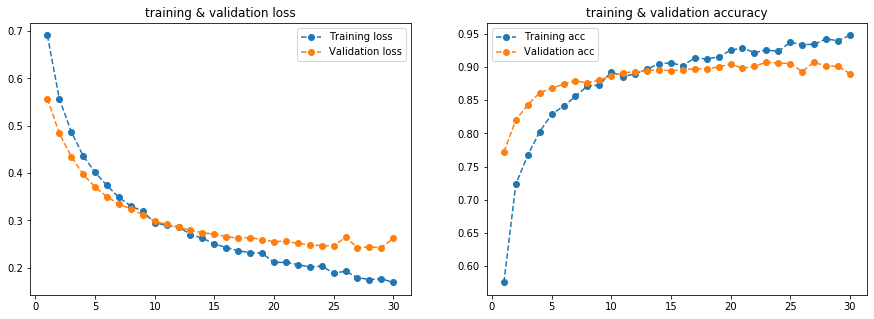

In [6]:
# ploting model training results
utility_obj.plot_training_history(history.history)

## Adding a densely-connected classifier on top of the convolutional base

In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## Freezing the convolutional base

In [8]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


## Training the model end-to-end with a frozen convolutional base
<em>* reduce batch size if required</em>

In [9]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

batch_size = 512 

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

nb_train_samples = utility_obj.count_files_in_directory(train_dir)
nb_valid_samples = utility_obj.count_files_in_directory(validation_dir)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
print("\nModel training in progress..")
history = model.fit_generator(
      train_generator,
      steps_per_epoch= nb_train_samples // batch_size,
      epochs=50, verbose=0,
      validation_data=validation_generator,
      validation_steps=nb_valid_samples // batch_size)
print("Model training complete !!\n")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.

Model training in progress..
Model training complete !!



### Result

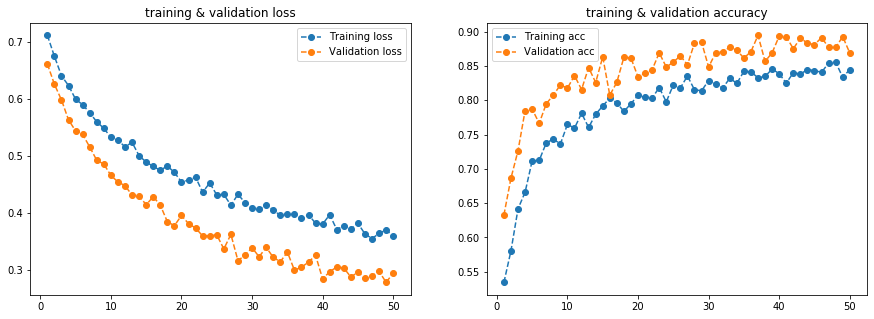

In [10]:
# ploting model training results
utility_obj.plot_training_history(history.history)

## Freezing all layers up to a specific one

In [11]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

## Fine-tuning our model

In [12]:
print("\nModel training in progress..")
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= nb_train_samples // batch_size,
      epochs=50, verbose = 0,
      validation_data=validation_generator,
      validation_steps=nb_valid_samples // batch_size)
print("Model training complete !!\n")


Model training in progress..
Model training complete !!



### Result

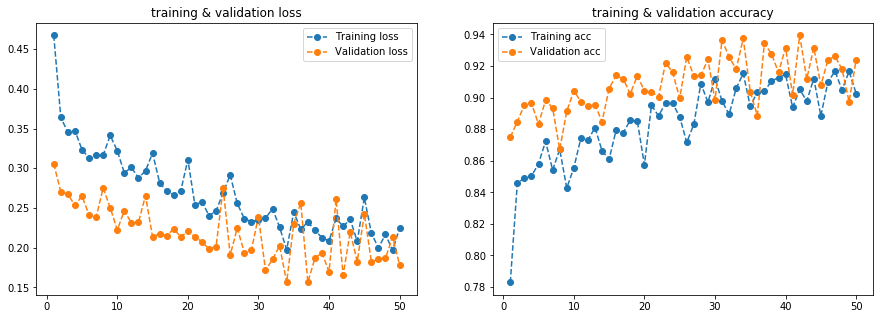

In [13]:
# ploting model training results
utility_obj.plot_training_history(history.history)